# Init

In [ ]:
!pip install tqdm

In [ ]:
!pip install nltk

In [1]:
import datetime
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# Read the data

In [568]:
df = pd.read_csv(
    "../data/train_data_cleaned.csv",
    # Note: some of the variables should be treated as 
    dtype={"year_week": str, "recipe_id": str},
)
df.head()

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales
0,201801,14919,Shrimp & Broccoli Stir-Fry,2 person,687.0,99.2,time_level_4,asian,"For this dish, once the ingredients are prepped, dinner will be hot and on the table in a matter...",easy,fish,optional_heat,18.6,No,7,shellfish,rice,"fish_and_side,stir_fry",all_seasons,shellfish,29.5,main,NaN,healthy_choice,0.0,NaN,3567
1,201801,14920,Caramelized Cabbage Pasta,2 person,779.0,81.3,time_level_4,new_american,"Red lentil penne makes this pasta dish a pleasure to look at, but also a pleasure to eat! The tr...",easy,veggie,no_heat,38.5,No,5,no_protein,pasta_incl_gnocchi_spatzle,pasta,all_seasons,no_protein,30.0,main,NaN,quick,0.0,no_cut,2532
2,201801,14449,AFC Vegetarian Pad Thai,z_amazon,642.0,92.8,NaN,NaN,"Pad Thai is one of our favorite street foods to recreate at home. Typically, it requires a lot o...",easy,veggie,NaN,25.6,No,10,NaN,NaN,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,6
3,201801,11963,Shrimp & Broccoli Stir-Fry,family,620.0,93.2,time_level_4,asian,"For this dish, once the ingredients are prepped, dinner will be hot and on the table in a matter...",easy,fish,optional_heat,13.7,No,7,shellfish,rice,"fish_and_side,stir_fry",all_seasons,shellfish,28.7,main,NaN,healthy_choice,0.0,NaN,642
4,201801,14914,Chicken & Pasta Soup,family,610.0,67.0,time_level_4,new_american,"We've never met a chicken soup we didn't like, but we particularly love how comforting and heart...",easy,meat,no_heat,20.0,No,7,poultry,"sweet_potato,pasta_incl_gnocchi_spatzle",soup,all_seasons,poultry,36.0,main,NaN,healthy_choice,0.0,breast,1492


In [569]:
# df = df[df.product_type.isin(["2 person", "family"])]
df["recipe_name_clean"] = (df
    .recipe_name
    .apply(lambda text: text.lower().strip())
    .replace({
        "chile-lime fish tacos": "chili-lime fish tacos",
        "spicy shrimp noodles": "spicy shrimp ramen",
        "grilled berkshire pork": "grilled pork wraps",
        "spiced berkshire pork": "spiced pork tenderloin steaks",
        "moroccan pork tenderloin": "moroccan-spiced berkshire pork",
        "orecchiette and sausage": "orecchiette & sausage",
    })
)

In [570]:
# # Sanity checks
# assert (df.groupby(["year_week", "recipe_name_clean"]).count().recipe_id == 1).sum() == 0

In [571]:
feature_might_require_substitution = [
    "cuisine",
    "dish_type",
    "heat_level",
    "preferences",
    "carbs_content",
    "dish_types",
    "seasons",
    "protein_types",
    "meta_tags",
    "protein_cuts",
#     "course_type",
#     "difficulty",
#     "is_classic",
#     "percentage_of_local_ingredients",
]

# Functions

In [572]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [573]:
def clean_data(df):
    df["week_day"] = df.year_week.apply(
        lambda year_week: datetime.datetime.strptime(year_week + '-1', "%G%V-%u")
    )
    df["close_to_new_year"] = df.year_week.str.endswith(("01", "02", "52", "51", "50")).astype(int)
    df["n_words"] = df.description.fillna("").str.len()
    df["month"] = df.week_day.dt.month
    df = df.merge(
        (df
         .groupby("year_week")
         .agg({"recipe_id": "count", "sales": "sum"})
         .rename(columns={"recipe_id": "count", "sales": "total_sales"})),
        how="left",
        left_on="year_week",
        right_index=True,
    )
#     df_stats = df.sort_values("year_week").groupby(["recipe_name_clean", "product_type"]).cumcount()
    df_stats = df.sort_values("proteins", ascending=False).groupby(["year_week"]).calories.rank()
    df_stats.name = "cumcount"
    df = df.merge(df_stats, how="left", left_index=True, right_index=True)
    return df

# Train/validation split

In [736]:
date_start = "201936"
date_end = "201944"

# date_start = "201928"
# date_end = "201936"

# date_start = "201920"
# date_end = "201928"

# date_start = "201938"
# date_end = "201944"

# date_start = "201932"
# date_end = "201938"

df_clean = clean_data(df.copy())
df_train = df_clean[df_clean.year_week <= date_start]
print(df_train.shape)
df_validation = df_clean[(df_clean.year_week > date_start) & (df_clean.year_week <= date_end)]
assert len(df_validation.year_week.unique()) == 8, len(df_validation.year_week.unique())

# assert (len(df_train) + len(df_validation)) == len(df)

(2611, 35)


# Baseline model - constant average prediction

In [737]:
rmse(df_validation.sales, [df_train["sales"].mean()] * len(df_validation))

3782.4649535100893

# Best simplest model with categorical and numerical features

In [738]:
# def process_data(df):
#     df = (df
#      .groupby("year_week")
#      .agg({"sales": "sum", "recipe_id": "count", "week_day": "first"})
#      .rename(columns={"recipe_id": "count"})
#     )
#     df["month"] = df.week_day.dt.month
#     return df

# data_train = process_data(df_train)
# data_val = process_data(df_validation)

In [739]:
# df_train_agg = pd.concat([
#     data_train[["count"]],
#     pd.DataFrame(X_train.A).groupby(df_train.year_week.values).sum()
# ], axis=1)
# X_train_agg = (
#     df_train[["year_week"]].merge(
#         df_train_agg, how="left", left_on="year_week", right_index=True
#     ).drop("year_week", axis=1)
# )

In [740]:
# df_val_agg = pd.concat([
#     data_val[["count"]],
#     pd.DataFrame(X_val.A).groupby(df_validation.year_week.values).sum()
# ], axis=1)
# X_val_agg = (
#     df_validation[["year_week"]].merge(
#         df_val_agg, how="left", left_on="year_week", right_index=True
#     ).drop("year_week", axis=1)
# )

In [741]:
# X_train = sparse.hstack([X_train, X_train_agg.values])
# X_val = sparse.hstack([X_val, X_val_agg.values])

In [742]:
!pip install category_encoders

In [743]:
X_train

<2291x79 sparse matrix of type '<class 'numpy.float64'>'
	with 38116 stored elements in COOrdinate format>

In [749]:
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from category_encoders.ordinal import OrdinalEncoder

categorical_features = [
    'product_type',
    'course_type',
    'dish_type',
    'protein_cuts',
    'heat_level',
#     "protein_cuts",
#     "recipe_name_clean",
    
#     'preferences',
#     'cooking_time',
#     'seasons
]
numerical_features = [
    "proteins",
    "number_of_ingredients_per_recipe",
    "fat",
    "carbs",
    "calories",
#     "count",
#     "cumcount",
#     "n_words",
#     "close_to_new_year",
]
# Note: text features didn't help
text_features = [
    "recipe_name_clean",
    "protein_types",
    "meta_tags",
    "carbs_content",
    "cuisine",
#     "dish_types",
#     "seasons",',
#     "cuisine",
#     "description",
]

product_type = "2 person"
df_train_cleaned = df_train#[df_train.product_type == product_type]
df_val_cleaned = df_validation#[df_validation.product_type == product_type]

# Note: tree will work faster with ordinal encoded feature, but one hot encoded features
# make it easier to transition from models based on the numerical features to the models based
# on the decision trees. Since there is quite little data it's much more efficient to use
# one encoder for all of the experiments.
# encoder = OneHotEncoder(handle_unknown="ignore")
encoder = OrdinalEncoder(handle_unknown="ignore")
X_train = encoder.fit_transform(df_train_cleaned[categorical_features].fillna("UNK").astype(str))
X_train = np.hstack((X_train, df_train_cleaned[numerical_features]))
y_train = df_train_cleaned["sales"]

X_val = encoder.transform(df_val_cleaned[categorical_features].fillna("UNK").astype(str))
X_val = np.hstack((X_val, df_val_cleaned[numerical_features]))
y_val = df_val_cleaned["sales"]

for text_feature in text_features:
    if text_feature == "description":
        name_vectorizer = TfidfVectorizer(min_df=100, stop_words="english")
    else:
        name_vectorizer = TfidfVectorizer(min_df=50, stop_words="english")
    X_train_name = name_vectorizer.fit_transform(df_train_cleaned[text_feature].fillna("").replace(",", " "))
    X_val_name = name_vectorizer.transform(df_val_cleaned[text_feature].fillna("").replace(",", " "))

    X_train = sparse.hstack([X_train, X_train_name])
    X_val = sparse.hstack([X_val, X_val_name])
    
# X_train = sparse.hstack([X_train, np.array(vectors_desc_train)])
# X_val = sparse.hstack([X_val, np.array(vectors_desc_val)])


print(X_train.shape)
print(X_val.shape)

(2611, 85)
(328, 85)


In [748]:
import lightgbm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=200, min_samples_leaf=10)#, max_features=100)
# model = DecisionTreeRegressor(min_samples_leaf=100)
# model = SVR()

model = lightgbm.LGBMRegressor(
    n_estimators=300,
    num_leaves=7,
    max_depth=3,
    objective="rmse",
    learning_rate=0.02,
    colsample_bytree=0.5,
    verbosity=-1,
    extra_trees=True,
#     bagging_freq=10,
#     path_smooth=0.1,
#     lambda_l1=3.5,
)

model.fit(
    X_train,
    y_train,
    # Note: sample_weight helps to add more importance to the most recent obsevations
    sample_weight=((df_train_cleaned.week_day - df_train_cleaned.week_day.min()).dt.days + 1) ** 4,
#     eval_set=[(X_val, y_val)]
)
y_predicted = np.clip(model.predict(X_val), 0, np.inf)
rmse(y_val, y_predicted)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


2866.1238982566424

In [673]:
# from sklearn.neural_network import MLPRegressor
# model2 = MLPRegressor((300, 50), verbose=True, max_iter=200)
# model2.fit(X_train, y_train)
# y_predicted = model2.predict(X_val)
# print(rmse(y_val, y_predicted))

In [674]:
model.feature_importances_[:len(encoder.get_feature_names())]

array([244,   0,  42,   0,  18,   2,  36,  12,  13,  43,   0,   0,  52,
         6,   0,  11,   0,   5,   0,   2,   8,   0,  16,  35,   0,  30,
        11,   0,   6,   0,   3,  11], dtype=int32)

In [675]:
model.feature_importances_[len(encoder.get_feature_names()):]

array([ 30,  16,   5,  21,   6,  85,  23,   0,   0,   2,   0,   0,   1,
         1,   2,   0,  73,   0,  14,   0,   8,   0,  48,  20,  11,   1,
         7,  52,   1,   0,  36,  18,   0,   9,   0,   0,   2,   0,  31,
         0,   0,   0,   0, 136,   0,   0,   0,   0,   0,   2,   0,   0,
         0,   0,  31,   5,   0,   0,   0,   0,   3,   3,   0,  47,  32,
        83,   0,   3,  10,  11,  15,  43,  54,   0,   0,   0,   0,   2,
        14,   1,   0,  16], dtype=int32)

In [676]:
df_validation["sales_predicted"] = y_predicted
df_validation["diff"] = (y_predicted - y_val).abs()
df_validation.sort_values("diff")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount,sales_predicted,diff
2646,201937,35931,Vietnamese Fish Soup,family,410.0,58.0,time_level_5,asian,"Based on the Vietnamese dish called ""canh chua cá,"" this fish soup harmoniously balances sour, s...",easy,fish,no_heat,7.0,No,10,fish,rice,soup,NaN,fish,29.0,main,NaN,healthy_choice,0.0,NaN,50,vietnamese fish soup,2019-09-09,0,301,9,42,79013,1.0,53.348300,3.348300
2893,201943,35880,Chickpea Korma Curry,2 person,530.0,52.0,time_level_4,indian,You might have seen korma at your local Indian restaurant. It's usually meat and veggies simmere...,easy,veggie,no_heat,30.0,No,10,beans_pulses,gluten_free_grains,beans,autumn,beans_pulses,18.0,main,NaN,healthy_choice,0.0,no_cut,1263,chickpea korma curry,2019-10-21,0,277,10,40,81651,6.0,1257.127559,5.872441
2700,201939,36446,Greek-Style Broiled Cod,family,470.0,31.0,time_level_4,greek,"We channel all of the briny, savory, and fresh flavors of Greek cuisine in this one-pan dish. Fi...",easy,fish,no_heat,27.0,No,8,fish,potato,"fish_and_side,one_pot",NaN,fish,27.0,main,NaN,"healthy_choice,quick",0.0,NaN,298,greek-style broiled cod,2019-09-23,0,426,9,42,79919,3.0,281.266066,16.733934
2784,201941,36857,"Pierogi Ravioli with Sour Cream,",2 person,860.0,62.0,time_level_3,new_american,Combining the best of cheese pierogi with Italian ravioli sounds like a comfort food fever dream...,easy,veggie,no_heat,60.0,No,6,dairy,pasta_incl_gnocchi_spatzle,pasta,NaN,dairy,18.0,main,NaN,"kid_friendly,quick",0.0,no_cut,2731,"pierogi ravioli with sour cream,",2019-10-07,0,408,10,40,82899,28.0,2758.218052,27.218052
2766,201940,36624,Shrimp Scampi Pasta,family,810.0,91.0,time_level_4,new_american,"Shrimp scampi is an undying classic—it’s hard to beat the flavors of fresh garlic, parsley, and ...",easy,fish,no_heat,32.0,No,6,shellfish,pasta_incl_gnocchi_spatzle,pasta,all_seasons,shellfish,37.0,main,NaN,quick,0.0,NaN,484,shrimp scampi pasta,2019-09-30,0,383,9,42,81194,33.5,514.318189,30.318189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,201942,37025,Crispy Parm Chicken Tenders,2 person,1070.0,65.0,time_level_5,american,Parmesan and panko breadcrumbs are the perfect combo for coating tender chicken breast strips—th...,easy,meat,no_heat,64.0,No,9,poultry,potato,meat_and_side,NaN,poultry,59.0,main,NaN,kid_friendly,0.0,NaN,16498,crispy parm chicken tenders,2019-10-14,0,322,10,40,81562,38.5,3767.965179,12730.034821
2681,201938,36311,Roasted Chicken & Broccoli,2 person,860.0,69.0,time_level_5,new_american,We put a new spin on chicken and rice that's not just delicious but kind of a genius timesaver. ...,easy,meat,no_heat,42.0,No,7,"dairy,poultry",rice,"meat_and_side,oven_backed",all_seasons,"dairy,poultry",50.0,main,NaN,kid_friendly,0.0,breast,17346,roasted chicken & broccoli,2019-09-16,0,406,9,42,79539,33.0,4252.340058,13093.659942
2757,201940,36633,Chicken Fajita Bowl,2 person,660.0,105.0,time_level_4,new_american,"Fajitas are a pretty perfect meal. Except when you wrap one up and take a bite, only to have it ...",easy,meat,no_heat,25.0,No,9,poultry,rice,meat_and_side,all_seasons,poultry,43.0,main,NaN,"kid_friendly,healthy_choice",0.0,breast,16520,chicken fajita bowl,2019-09-30,0,389,9,42,81194,16.5,3416.440218,13103.559782
2811,201941,36783,Fontina-Sage Stuffed Chicken,2 person,920.0,55.0,time_level_5,italian,"We don't know about you, but it just wouldn't be fall for us without some fresh sage. It's what ...",easy,meat,no_heat,54.0,No,9,poultry,potato,meat_and_side,NaN,poultry,52.0,main,NaN,kid_friendly,0

In [661]:
name = pd.Series(list(set(df_train.recipe_name_clean) & set(df_validation.recipe_name_clean))).sample(1).values[0]
print(name)
display(
    df_train[df_train.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
        ["year_week", "product_type"]
    )
)
df_validation[df_validation.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
    ["year_week", "product_type"]
)

rosemary-garlic steak


,year_week,sales,product_type,total_sales
1409,201905,17276,2 person,77497
1416,201905,3771,family,77497


,year_week,sales,product_type,total_sales
2907,201944,16694,2 person,80493
2915,201944,4320,family,80493


In [695]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)


In [663]:
df_validation.sort_values(["year_week", "recipe_name_clean"]).head(20)

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount,sales_predicted,diff
2626,201937,36030,Beef Taquitos,2 person,940.0,69.0,time_level_5,mexican,"Contrary to popular belief, tomatillos are not green tomatoes, but they could be considered a di...",easy,meat,high,54.0,No,9,"beef,spicy",tortillas_and_wraps,oven_backed,NaN,beef,44.0,main,NaN,kid_friendly,0.0,NaN,13986,beef taquitos,2019-09-09,0,368,9,42,79013,39.0,2736.134364,11249.865636
2627,201937,36031,Beef Taquitos,family,810.0,62.0,time_level_5,mexican,"Contrary to popular belief, tomatillos are not green tomatoes, but they could be considered a di...",easy,meat,high,43.0,No,9,"beef,spicy",tortillas_and_wraps,oven_backed,NaN,beef,42.0,main,NaN,kid_friendly,0.0,NaN,3370,beef taquitos,2019-09-09,0,368,9,42,79013,35.5,799.952482,2570.047518
2611,201937,35978,Broken Noodle Paella,2 person,810.0,113.0,time_level_4,european,"We riff on the iconic Spanish dish, taking a page from fideua, a Catalan dish similar to paella—...",easy,veggie,no_heat,29.0,No,9,beans_pulses,pasta_incl_gnocchi_spatzle,pasta,NaN,beans_pulses,27.0,main,NaN,quick,0.0,NaN,871,broken noodle paella,2019-09-09,0,423,9,42,79013,35.5,1995.496334,1124.496334
2618,201937,35979,Broken Noodle Paella,family,590.0,80.0,time_level_4,european,"We riff on the iconic Spanish dish, taking a page from fideua, a Catalan dish similar to paella—...",easy,veggie,no_heat,23.0,No,9,beans_pulses,pasta_incl_gnocchi_spatzle,pasta,NaN,beans_pulses,18.0,main,NaN,quick,0.0,NaN,128,broken noodle paella,2019-09-09,0,423,9,42,79013,11.5,576.716589,448.716589
2612,201937,35977,Butterflied Pork Tenderloin,family,790.0,19.0,time_level_5,eastern_european,Gremolata is an Italian topping that adds a freshness to dishes. It's traditionally made by comb...,easy,meat,no_heat,50.0,No,9,"dairy,pork",low_carb,meat_and_side,NaN,"dairy,pork",63.0,main,NaN,kid_friendly,0.0,NaN,131,butterflied pork tenderloin,2019-09-09,0,403,9,42,79013,32.5,695.429550,564.429550
2635,201937,35976,Butterflied Pork Tenderloin,2 person,820.0,21.0,time_level_5,eastern_european,Gremolata is an Italian topping that adds a freshness to dishes. It's traditionally made by comb...,easy,meat,no_heat,54.0,No,9,"dairy,pork",low_carb,meat_and_side,NaN,"dairy,pork",63.0,main,NaN,kid_friendly,0.0,NaN,1097,butterflied pork tenderloin,2019-09-09,0,403,9,42,79013,37.0,3347.426191,2250.426191
2613,201937,35975,Chicken Piccata Meatballs,family,630.0,13.0,time_level_5,italian,"Low carb doesn't mean boring! Fresh lemon, briny capers, and sweet shallots come together to mak...",easy,meat,no_heat,48.0,No,9,"dairy,poultry",low_carb,meat_and_side,NaN,"dairy,poultry",35.0,main,NaN,"kid_friendly,healthy_choice",0.0,NaN,733,chicken piccata meatballs,2019-09-09,0,314,9,42,79013,16.0,985.887157,252.887157
2619,201937,35974,Chicken Piccata Meatballs,2 person,800.0,16.0,time_level_5,italian,"Low carb doesn't mean boring! Fresh lemon, briny capers, and sweet shallots come together to mak...",easy,meat,no_heat,64.0,No,9,"dairy,poultry",low_carb,meat_and_side,NaN,"dairy,poultry",38.0,main,NaN,"kid_friendly,healthy_choice",0.0,NaN,4755,chicken piccata meatballs,2019-09-09,0,314,9,42,79013,34.0,3093.648994,1661.351006
2632,201937,36465,Coconut Shrimp Masala,family,590.0,67.0,time_level_4,indian,"Thanks to quick-cooking Gulf shrimp, this dish comes together in no time at all! We take some he...",easy,fish,high,23.0,No,10,"shellfish,spicy",rice,fish_and_side,all_seasons,shellfish,27.0,main,NaN,"healthy_choice,quick",0.0,NaN,395,coconut shrimp masala,2019-09-09,0,419,9,42,79013,11.5,43.066141,351.933859
2639,201937,36464,Coconut Shrimp Masala,2 person,720.0,9

In [ ]:
df_validation

In [709]:
print(df_validation.sort_values("diff").iloc[-5])
# print(df_validation.sort_values("diff").iloc[[-1, -2, -3]].description)

year_week                                        201942
recipe_id                                         37025
recipe_name                         Crispy Parm Chic...
product_type                                   2 person
calories                                           1070
carbs                                                65
cooking_time                               time_level_5
cuisine                                        american
description                         Parmesan and pan...
difficulty                                         easy
dish_type                                          meat
heat_level                                      no_heat
fat                                                  64
is_classic                                           No
number_of_ingredients_per_recipe                      9
preferences                                     poultry
carbs_content                                    potato
dish_types                                meat_a

In [716]:
df_train[df_train.recipe_name_clean == df_validation.sort_values("diff").iloc[-6].recipe_name_clean]

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount
189,201806,15223,Chicken Schnitze...,family,765.0,76.0,time_level_5,german,Schnitzel is a G...,easy,meat,no_heat,32.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,44.0,main,NaN,kid_friendly,0.0,breast,3890,chicken schnitze...,2018-02-05,0,400,2,44,76306,23.0
194,201806,15222,Chicken Schnitze...,2 person,856.0,83.0,time_level_4,german,Schnitzel is a G...,easy,meat,no_heat,40.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,45.0,main,NaN,kid_friendly,0.0,breast,18211,chicken schnitze...,2018-02-05,0,400,2,44,76306,33.0
1209,201848,15223,Chicken Schnitze...,family,765.0,76.0,time_level_5,german,Schnitzel is a G...,easy,meat,no_heat,32.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,44.0,main,NaN,kid_friendly,0.0,breast,793,chicken schnitze...,2018-11-26,0,400,11,20,85879,14.0
1214,201848,15222,Chicken Schnitze...,2 person,856.0,83.0,time_level_4,german,Schnitzel is a G...,easy,meat,no_heat,40.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,45.0,main,NaN,kid_friendly,0.0,breast,3064,chicken schnitze...,2018-11-26,0,400,11,20,85879,17.0
1546,201910,15222,Chicken Schnitze...,2 person,856.0,83.0,time_level_4,german,Schnitzel is a G...,easy,meat,no_heat,40.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,45.0,main,NaN,kid_friendly,0.0,breast,1334,chicken schnitze...,2019-03-04,0,400,3,40,97148,36.0
1549,201910,15223,Chicken Schnitze...,family,765.0,76.0,time_level_5,german,Schnitzel is a G...,easy,meat,no_heat,32.0,No,7,poultry,"potato,panko_and...",meat_and_side,all_seasons,poultry,44.0,main,NaN,kid_friendly,0.0,breast,335,chicken schnitze...,2019-03-04,0,400,3,40,97148,29.0


In [711]:
display(df_validation.sort_values("diff").iloc[[-1, -2, -3, -4, -5, -6, -7, -8]].sort_values("year_week"))
# print(df_validation.sort_values("diff").iloc[[-1, -2, -3]].description)

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount,sales_predicted,diff
2626,201937,36030,Beef Taquitos,2 person,940.0,69.0,time_level_5,mexican,Contrary to popu...,easy,meat,high,54.0,No,9,"beef,spicy",tortillas_and_wraps,oven_backed,NaN,beef,44.0,main,NaN,kid_friendly,0.0,NaN,13986,beef taquitos,2019-09-09,0,368,9,42,79013,39.0,2797.0,11189.015055
2681,201938,36311,Roasted Chicken ...,2 person,860.0,69.0,time_level_5,new_american,We put a new spi...,easy,meat,no_heat,42.0,No,7,"dairy,poultry",rice,"meat_and_side,ov...",all_seasons,"dairy,poultry",50.0,main,NaN,kid_friendly,0.0,breast,17346,roasted chicken ...,2019-09-16,0,406,9,42,79539,33.0,4252.0,13093.659942
2701,201939,36518,Skillet Chicken ...,2 person,1110.0,100.0,time_level_5,new_american,We're giving chi...,easy,meat,no_heat,43.0,No,7,poultry,pasta_incl_gnocc...,"pasta,meat_and_side",all_seasons,poultry,69.0,main,NaN,kid_friendly,0.0,breast,17174,skillet chicken ...,2019-09-23,0,344,9,42,79919,40.5,5900.0,11273.661598
2757,201940,36633,Chicken Fajita Bowl,2 person,660.0,105.0,time_level_4,new_american,Fajitas are a pr...,easy,meat,no_heat,25.0,No,9,poultry,rice,meat_and_side,all_seasons,poultry,43.0,main,NaN,"kid_friendly,hea...",0.0,breast,16520,chicken fajita bowl,2019-09-30,0,389,9,42,81194,16.5,3416.0,13103.559782
2811,201941,36783,Fontina-Sage Stu...,2 person,920.0,55.0,time_level_5,italian,We don't know ab...,easy,meat,no_heat,54.0,No,9,poultry,potato,meat_and_side,NaN,poultry,52.0,main,NaN,kid_friendly,0.0,NaN,17556,fontina-sage stu...,2019-10-07,0,385,10,40,82899,31.0,4389.0,13166.910141
2822,201942,37025,Crispy Parm Chic...,2 person,1070.0,65.0,time_level_5,american,Parmesan and pan...,easy,meat,no_heat,64.0,No,9,poultry,potato,meat_and_side,NaN,poultry,59.0,main,NaN,kid_friendly,0.0,NaN,16498,crispy parm chic...,2019-10-14,0,322,10,40,81562,38.5,3768.0,12730.034821
2874,201943,37873,Chicken Schnitze...,2 person,970.0,85.0,time_level_5,german,It's no wonder s...,easy,meat,no_heat,48.0,No,7,poultry,potato,meat_and_side,NaN,poultry,49.0,main,NaN,kid_friendly,0.0,breast,16969,chicken schnitze...,2019-10-21,0,303,10,40,81651,36.0,4423.0,12546.084120
2921,201944,36269,Moroccan-Spiced ...,2 person,850.0,52.0,time_level_5,mediterranean,Ras el hanout is...,easy,meat,no_heat,47.0,No,8,poultry,grains,meat_and_side,"spring,autumn,wi...",poultry,55.0,main,NaN,"healthy_choice,k...",0.0,NaN,16014,moroccan-spiced ...,2019-10-28,0,396,10,40,80493,31.5,2716.0,13297.768802


In [649]:
df_validation[df_validation.recipe_name_clean == "tarragon chicken"]

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount,sales_predicted,diff


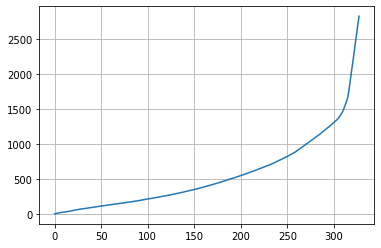

In [650]:
cum_errors = np.sqrt(((df_validation.sort_values("diff")["diff"] ** 2).cumsum() / (np.arange(len(df_validation)) + 1)))
plt.plot(cum_errors.values)
plt.grid()

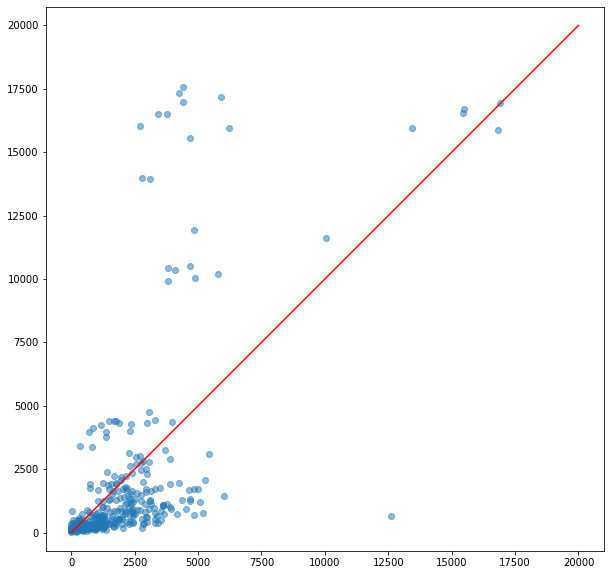

In [651]:
plt.figure(figsize=(10, 10))
plt.scatter(y_predicted, y_val, alpha=0.5)
plt.plot([0, 20_000], [0, 20_000], color="red")
plt.axis("equal");

<BarContainer object of 114 artists>

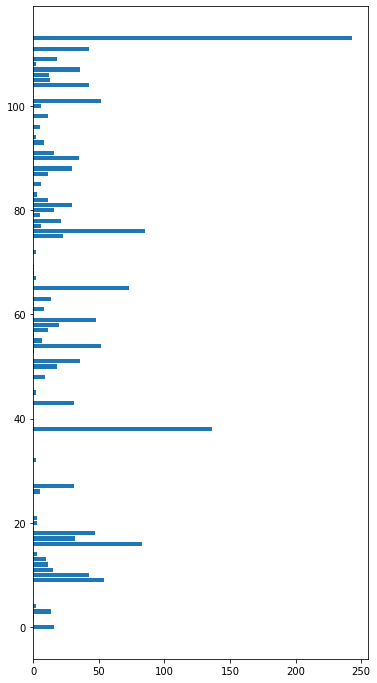

In [652]:
plt.figure(figsize=(6, 12))
plt.barh(
    np.arange(len(model.feature_importances_))[::-1],
    model.feature_importances_
)

IndexError: index 57 is out of bounds for axis 0 with size 44

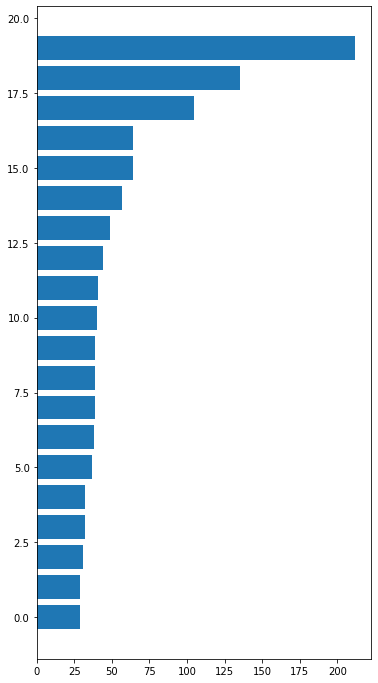

In [478]:
n_features = 20

feature_importances = model.feature_importances_
most_important_feature_indices = feature_importances.argsort()[-n_features:]
feature_names = np.asarray(
    encoder.get_feature_names(input_features=categorical_features).tolist()
    + numerical_features
    + name_vectorizer.get_feature_names()
)

plt.figure(figsize=(6, 12))
plt.barh(
    np.arange(n_features),
    feature_importances[most_important_feature_indices],
)
plt.yticks(
    np.arange(n_features),
    feature_names[most_important_feature_indices]
);

In [689]:
df_validation["sales_predicted"] = y_predicted.round()
df_validation.groupby("year_week").agg({"sales_predicted": sum, "sales": sum})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sales_predicted,sales
year_week,,
201937,72549.0,79013
201938,83953.0,79539
201939,89201.0,79919
201940,94658.0,81194
201941,81068.0,82899
201942,79848.0,81562
201943,82427.0,81651
201944,81327.0,80493


Model that has been tested
- Linearn model
- Decision tree
- Neural network (in order to train directly with the RMSE loss function)
- Random forest

In [378]:
# from neupy.layers import *
# from neupy.algorithms import *

# optimizer = GradientDescent(
#     [
#         Input(X_train.shape[1]),
#         Relu(50),
#         Relu(1),
#     ],
#     step=0.1,
#     regularizer=l2(0.0001),
#     loss="rmse",
#     verbose=True,
#     show_epoch=1,
#     batch_size=None,
# )
# optimizer.train(X_train.A, y_train / 10000, X_val.A, y_val / 10000, epochs=10)

# Make one prediction per each week

     |████████████████████████████████| 1.4 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 662 kB 5.3 MB/s eta 0:00:01     |████████████████████████████▊   | 593 kB 5.3 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=e35d7995bb135f5f8c150ae1a941d0d365e07ce00c27ccb653e5817225dbec19
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk


In [166]:
from tqdm.notebook import tqdm

embeddings_dict = {}
with open("../data/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [175]:
df_train.description.str.lower().iloc[0]

'for this dish, once the ingredients are prepped, dinner will be hot and on the table in a matter of minutes! succulent shrimp, and crisp-tender veggies are coated in a sweet and slightly spicy chili sauce. this dish has all the hallmarks of take-out—quick, easy, and tasty—but with the feel-good factor of home-cooking. cook, relax, and enjoy!'

In [176]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [186]:
df_train.description[df_train.description.str.len() < 5]

775    TK
776    TK
Name: description, dtype: object

In [243]:
from nltk.tokenize import sent_tokenize, word_tokenize 

vectors_desc_train = []
for desc in tqdm(df_train.recipe_name):
    if not pd.isnull(desc):
        tokens = word_tokenize(desc)
        vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
        if len(vectors) == 0:
            vector = np.zeros(50)
        else:
            vector = sum(vectors) / len(vectors)
    else:
        vector = np.zeros(50)
    vectors_desc_train.append(vector)

In [244]:
from nltk.tokenize import sent_tokenize, word_tokenize 

vectors_desc_val = []
for desc in tqdm(df_validation.recipe_name):
    if not pd.isnull(desc):
        tokens = word_tokenize(desc)
        vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
        if len(vectors) == 0:
            vector = np.zeros(50)
        else:
            vector = sum(vectors) / len(vectors)
    else:
        vector = np.zeros(50)
    vectors_desc_val.append(vector)

array([[ 0.19156714,  0.1636131 , -0.36368555, ..., -0.20352122,
         0.00204504,  0.01605258],
       [ 0.25221002,  0.17608082, -0.3350805 , ..., -0.13049103,
         0.01700729,  0.08436444],
       [ 0.18614654,  0.17984657, -0.15928929, ..., -0.2422251 ,
         0.04740877,  0.1167558 ],
       ...,
       [ 0.12314255,  0.15801647, -0.56988019, ..., -0.21288578,
        -0.09541043, -0.06121797],
       [ 0.31390524,  0.08754121, -0.28277689, ..., -0.13281037,
         0.0189186 ,  0.04833094],
       [ 0.12314255,  0.15801647, -0.56988019, ..., -0.21288578,
        -0.09541043, -0.06121797]])

In [193]:
pd.isnull(desc)

True

In [184]:
desc

'TK'

In [181]:
vectors

array([ 1.1494028e+01,  9.8167858e+00, -2.1821133e+01,  6.3550143e+00,
        2.3305105e+01,  1.2959874e+01, -1.5280391e+01, -1.2872482e+01,
       -1.0153338e+01,  2.8290381e+00, -1.6848295e+00,  2.1418743e+00,
        2.4764943e+00,  3.5825613e+00,  1.5665058e+01,  7.5802193e+00,
        1.2429785e+00,  5.5318193e+00, -1.9336147e+01, -2.4781830e+01,
        6.5038767e+00,  3.0287316e+00,  3.2779163e+01,  3.7097418e+00,
       -3.0001247e-01, -7.0419968e+01, -1.9247719e+01,  1.8227037e+01,
        2.0840544e+01, -1.7133116e+01,  1.7999492e+02,  1.0129978e+01,
       -1.2392168e+01,  2.0480504e+00,  7.3360953e+00,  1.5888898e+00,
       -5.1569943e+00,  2.0803093e+01,  1.1366050e+01, -4.9164071e+00,
       -2.8386741e+00,  1.3071936e+01, -6.7658281e-01, -1.0716534e+00,
        1.1151993e+01,  2.0126717e+01, -5.4888883e+00, -1.2211273e+01,
        1.2270230e-01,  9.6315491e-01], dtype=float32)